In [1]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
#sns.set_style("darkgrid")
#sns.set_context("poster")
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
%matplotlib inline
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np
import copy
import re

import matplotlib.ticker as mticker

import matplotlib.colors as mcolors
#palette = list(mcolors.TABLEAU_COLORS.keys())
#palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [2]:
def RR2Asp(RR):
    return(54.863 * (RR**1.0646))
def RR2Asn(RR):
    return(60.033 * (RR**0.9177))

In [3]:
### Read measurements

annotation_df = pd.read_excel('annotation_df.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('143B-2xGOT-KO_300uM-Asp_UCPH-titration.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['Response Ratio']) != 0:
            metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['ISTD Response']
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = [v.split('_')[-1] for v in metab_dict_mes[k]['Filename']]
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['Dilution_factor']
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Flag Details'], axis=1)

In [4]:
metab_dict_mes['NADH pos']

,Compound,RT,Response,Sample ID,Formula,Response Ratio,ISTD Response,Sample_name,UCPH,Dilution_factor,Proliferation_rate,Proliferation_rate_stdev,Cell_line,Salvage_mix
0,NADH pos,9,0.639387,0.0,C21H29N7O14P2,0.007992,2364407051,UH20,6.0,0.0125,0.525135,0.006753,DKO,No
1,NADH pos,9,0.536733,0.0,C21H29N7O14P2,0.006709,2398590144,UH19,6.0,0.0125,0.525135,0.006753,DKO,No
2,NADH pos,9,0.436469,0.0,C21H29N7O14P2,0.005456,2313181535,UH18,4.0,0.0125,0.707085,0.017186,DKO,No
3,NADH pos,9,0.433551,0.0,C21H29N7O14P2,0.005419,2259175349,UH17,4.0,0.0125,0.707085,0.017186,DKO,No
4,NADH pos,9,0.457930,0.0,C21H29N7O14P2,0.005724,2317833579,UH16,2.0,0.0125,1.003488,0.007006,DKO,No
5,NADH pos,9,0.542454,0.0,C21H29N7O14P2,0.006781,2369986928,UH15,2.0,0.0125,1.003488,0.007006,DKO,No
6,NADH pos,9,0.356939,0.0,C21H29N7O14P2,0.004462,2263544401,UH14,1.0,0.0125,1.230966,0.040566,DKO,No
7,NADH pos,9,0.336990,0.0,C21H29N7O14P2,0.004212,2255340320,UH13,1.0,0.0125,1.230966,0.040566,DKO,No
8,NADH pos,9,0.302837,0.0,C21H29N7O14P2,0.003785,2429595805,UH12,0.1,0.0125,1.328586,0.020359,DKO,No
9,NADH pos,9,0.330608,0.0,C21H29N7O14P2,0.004133,2352534651,UH11,0.1,0.0125,1.328586,0.020359,DKO,No


In [5]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']
    
    if 'Aspartate' in nam:
        df['Aspartate conc'] = RR2Asp(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['Dilution_factor'].values
    elif 'Asparagine' in nam:
        df['Asparagine conc'] = RR2Asn(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['Dilution_factor'].values

In [6]:
df['NAD-NADH'] = (df['NAD pos'] / df['NADH pos']).replace(np.inf, np.nan)
df['Pyr-Lac'] = (df['Pyruvate neg'] / df['Lactate neg']).replace(np.inf, np.nan)
df['IMP-AMP'] = (df['IMP pos'] / df['AMP pos']).replace(np.inf, np.nan)
df['GSH-GSSG'] = (df['Glutathione pos'] / df['Glutathione disulfide pos']).replace(np.inf, np.nan)

#df['Aspartate conc'] = RR2Asp(df['Aspartate neg'].values) / df['Dilution_factor'].values
#df['Asparagine conc'] = RR2Asn(df['Asparagine pos'].values) / df['Dilution_factor'].values

In [7]:
# Normalize metabolites except Asp:
df_norm = copy.deepcopy(df)
mask0 = df_norm['UCPH'] == 0.1
for col in df.columns:
    for cell_line in ['WT', 'DKO']:
        mask_cl = df_norm['Cell_line'] == cell_line
        if col == 'Aspartate conc' or col == 'Asparagine conc':
            continue
        if 'neg' in col or 'pos' in col or 'conc' in col or 'NAD-NADH' in col:
            df_norm.loc[mask_cl, col] = df_norm.loc[mask_cl, col].values / np.mean(df_norm.loc[(mask0&mask_cl), col])

In [8]:
df_mean = df.groupby(['UCPH', 'Cell_line']).mean().reset_index()
df_stdev = df.groupby(['UCPH', 'Cell_line']).std().reset_index()

df_norm_mean = df_norm.groupby(['UCPH', 'Cell_line']).mean().reset_index()
df_norm_stdev = df_norm.groupby(['UCPH', 'Cell_line']).std().reset_index()

In [9]:
df_norm_mean

,UCPH,Cell_line,Sample ID,ISTD Response,Dilution_factor,Proliferation_rate,Proliferation_rate_stdev,Adenosine pos,ADP pos,Alanine pos,...,Threonine neg,Tryptophan pos,Tyrosine pos,UDP neg,UMP neg,Valine pos,NAD-NADH,Pyr-Lac,IMP-AMP,GSH-GSSG
0,0.1,DKO,0.0,6.280626e+09,0.0125,1.328586,0.020359,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.029244,3.727466e+06,0.406381
1,0.1,WT,0.0,6.316915e+09,0.0125,1.333468,0.026577,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.042025,1.625132e+06,0.422898
2,1.0,DKO,0.0,6.423471e+09,0.0125,1.230966,0.040566,0.938274,0.845977,0.882578,...,1.151185,1.205804,1.174893,0.760392,0.896668,1.164434,0.923562,0.028890,1.848589e+07,0.447648
3,1.0,WT,0.0,6.203916e+09,0.0125,1.314722,0.032551,0.963157,0.989418,1.039033,...,0.981150,1.045479,1.037044,1.054363,1.075528,1.018507,1.113821,0.040632,2.041573e+06,0.473151
4,2.0,DKO,0.0,6.280086e+09,0.0125,1.003488,0.007006,1.976241,0.899387,1.722394,...,1.211103,1.211967,1.187502,0.747953,0.819683,1.153087,0.595176,0.017930,2.938742e+07,0.420669
5,2.0,WT,0.0,6.289848e+09,0.0125,1.339674,0.017928,1.203002,1.037182,1.258829,...,1.017886,1.126283,1.105724,1.088158,0.958617,1.061410,0.972865,0.040531,1.337692e+06,0.459409
6,4.0,DKO,0.0,6.273491e+09,0.0125,0.707085,0.017186,1.041323,0.774762,2.422304,...,1.249916,1.305253,1.241765,0.421617,0.584086,1.213940,0.712473,0.021041,2.020069e+07,0.520497
7,4.0,WT,0.0,6.352872e+09,0.0125,1.337361,0.009225,1.440456,1.122370,1.292724,...,0.983690,1.148233,1.094233,1.078090,1.405457,1.054368,0.926910,0.040342,8.563876e+05,0.468914
8,6.0,DKO,0.0,6.453763e+09,0.0125,0.525135,0.006753,1.687658,0.909993,3.615898,...,1.584534,1.700165,1.638953,0.469199,0.685261,1.523292,0.604023,0.025256,6.304926e+07,0.447727
9,6.0,WT,0.0,6.349804e+09,0.0125,1.308255,0.031111,3.288754,1.342345,1.515162,...,1.036202,1.270591,1.199472,1.517184,2.216946,1.140076,1.012037,0.043176,6.404440e+05,0.628490


In [10]:
df_norm_mean['Aspartate conc']

0    9165.051408
1     670.571389
2     666.764193
3     620.139960
4     153.630538
5     529.601474
6      86.540364
7     514.665209
8      42.357444
9     501.056200
Name: Aspartate conc, dtype: float64

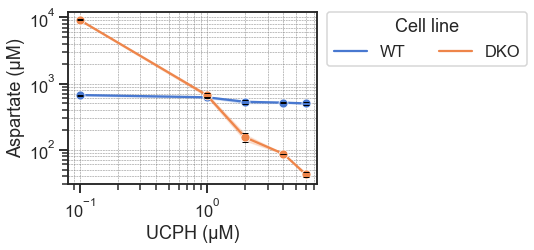

In [18]:
### Aspartate as a function of UCPH ###

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))

g1 = sns.lineplot(ax=ax1, data=df, x='UCPH', y='Aspartate conc', hue='Cell_line', markers=True, marker='o', hue_order=['WT', 'DKO'])
g1.errorbar(y=df_mean['Aspartate conc'].values, x=df_mean['UCPH'].values, yerr=df_stdev['Aspartate conc'].values, fmt='none', color='black', capsize=3)


g1.set(yscale="log", xscale="log");
g1.grid(True, which="both", ls="--", c='gray', linewidth=0.5)

g1.set(ylabel='Aspartate (μM)', xlabel='UCPH (μM)')

g1.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0, ncol=2, title='Cell line')


fig.tight_layout()
fig.savefig('plots/UCPH_vs_Asp.pdf', bbox_inches='tight')

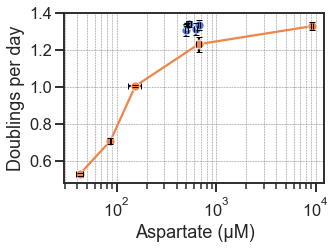

In [27]:
### Proliferation rate as a function of Aspartate ###

fig, ax2 = plt.subplots(1, 1, figsize=(5, 3.8))
g2 = sns.lineplot(ax=ax2, data=df_mean, x='Aspartate conc', y='Proliferation_rate', hue='Cell_line', 
                 markers=True, dashes=False, marker='o', hue_order=['WT', 'DKO'])
g2.errorbar(y=df_mean['Proliferation_rate'].values, x=df_mean['Aspartate conc'].values, xerr=df_stdev['Aspartate conc'].values, yerr=df_mean['Proliferation_rate_stdev'].values, fmt='none', color='black', capsize=3)
g2.grid(True, which="both", ls="--", c='gray', linewidth=0.5)

g2.set(xscale="log")
#g2.set(ylim=[0,1.4]);
#g2.set(xlim=[5000, 50000]);
g2.legend_.remove()

g2.set(xlabel='Aspartate (μM)', ylabel='Doublings per day')

### Stupid hack to get rid of overlapping label:
g2.xaxis.get_minorticklabels()[17].set_visible(False)



plt.tight_layout()
fig.savefig('plots/Asp_vs_Proliferation.pdf')

In [23]:
if False:

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.8))


    g1 = sns.lineplot(ax=ax1, data=df, x='UCPH', y='Aspartate conc', hue='Cell_line', markers=True, dashes=False)
    g1.set(yscale="log", xscale="log");
    g1.grid(True, which="both", ls="--", c='gray', linewidth=0.5)

    g1.set(ylabel='Aspartate (μM)', xlabel='UCPH (μM)')




    g2 = sns.lineplot(ax=ax2, data=df_mean, x='Aspartate conc', y='Proliferation_rate',  hue='Cell_line', markers=True, dashes=False)
    g2.errorbar(y=df_mean['Proliferation_rate'].values, x=df_mean['Aspartate conc'].values, xerr=df_stdev['Aspartate conc'].values, yerr=df_mean['Proliferation_rate_stdev'].values, fmt='none', color='black', capsize=3)
    g2.grid(True, which="both", ls="--", c='gray', linewidth=0.5)


    g2.set(xscale="log");
    #g2.set(ylim=[0,1.4]);

    g2.set(xlabel='Aspartate (μM)', ylabel='Doublings per day')

    ### Stupid hack to get rid of overlapping label:
    g2.xaxis.get_minorticklabels()[17].set_visible(False)



    plt.tight_layout()
    fig.savefig('combined-UCPH-Asp-prolif.pdf')

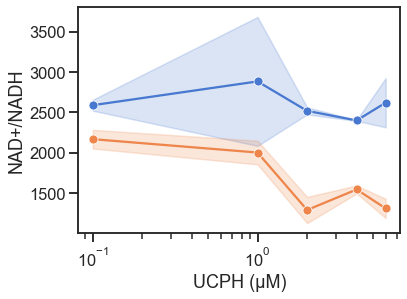

In [30]:
### NAD/NADH ratio as a function of UCPH ###

pdf = matplotlib.backends.backend_pdf.PdfPages("plots/UCPH_vs_NAD-NADH.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
g = sns.lineplot(data=df, x='UCPH', y='NAD-NADH', hue='Cell_line', markers=True, marker='o', hue_order=['WT', 'DKO'])
g.set(xscale="log");
g.legend_.remove()

plt.ylabel('NAD+/NADH')#, size=12);
plt.xlabel('UCPH (μM)')#, size=12);
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

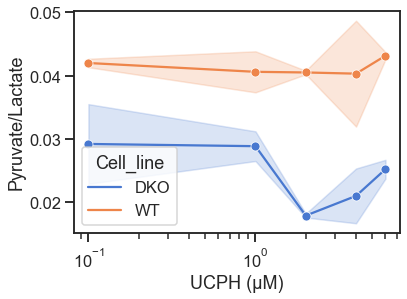

In [56]:

pdf = matplotlib.backends.backend_pdf.PdfPages("UCPH_vs_Pyr-Lac.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
g = sns.lineplot(data=df, x='UCPH', y='Pyr-Lac', hue='Cell_line', markers=True, marker='o')
g.set(xscale="log");

plt.ylabel('Pyruvate/Lactate')#, size=12);
plt.xlabel('UCPH (μM)')#, size=12);
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

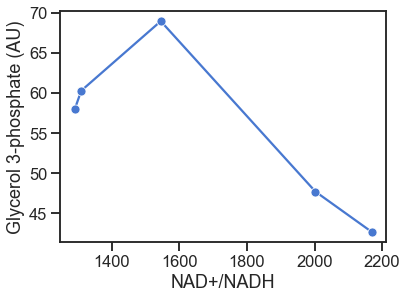

In [26]:
### Glycerol 3-phosphate as a function of NAD/NADH ratio ###

mask = df_mean['Cell_line'] == 'DKO'

pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_G3P.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean[mask], x='NAD-NADH', y='Glycerol 3-phosphate neg', markers=True, marker='o')

#g.errorbar(y=df_mean[mask1]['Glycerol 3-phosphate neg'].values, x=df_mean[mask1]['NAD-NADH'].values, yerr=df_stdev[mask1]['Glycerol 3-phosphate neg'].values, xerr=df_stdev[mask1]['NAD-NADH'].values, fmt='none', color='black', capsize=5)
#g.set(xscale="log");


plt.ylabel('Glycerol 3-phosphate (AU)')#, size=12);
plt.xlabel('NAD+/NADH')#, size=12);
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

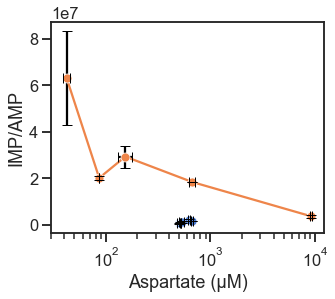

In [38]:
### IMP/AMP ratio as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("plots/Asp_vs_IMP-AMP_err.pdf")
fig = plt.figure(figsize=(5, 4.5))
#mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean, x='Aspartate conc', y='IMP-AMP', hue='Cell_line', markers=True, marker='o', hue_order=['WT', 'DKO'])

g.errorbar(y=df_mean['IMP-AMP'].values, x=df_mean['Aspartate conc'].values, xerr=df_stdev['Aspartate conc'].values, yerr=df_stdev['IMP-AMP'].values, fmt='none', color='black', capsize=5)
g.set(xscale="log");

g.legend_.remove()


plt.ylabel('IMP/AMP')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

26.402890393737444

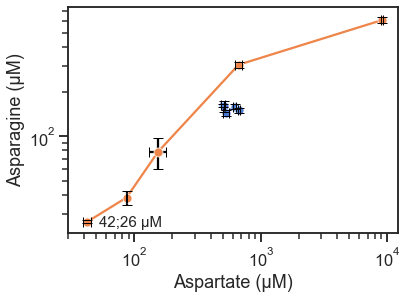

In [37]:
### Asparagine as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("plots/Asp_vs_Asn.pdf")
fig = plt.figure(figsize=(6, 4.5))
g = sns.lineplot(data=df_mean, x='Aspartate conc', y='Asparagine conc', hue='Cell_line', markers=True, marker='o', hue_order=['WT', 'DKO'])

g.errorbar(y=df_mean['Asparagine conc'].values, x=df_mean['Aspartate conc'].values, xerr=df_stdev['Aspartate conc'].values, yerr=df_stdev['Asparagine conc'].values, fmt='none', color='black', capsize=5)
g.set(yscale="log", xscale="log");

g.text(min(df_mean['Aspartate conc'])+10, min(df_mean['Asparagine conc'])-2, '{};{} μM'.format(round(min(df_mean['Aspartate conc'])), round(min(df_mean['Asparagine conc']))), size=15)

g.legend_.remove()

plt.ylabel('Asparagine (μM)')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

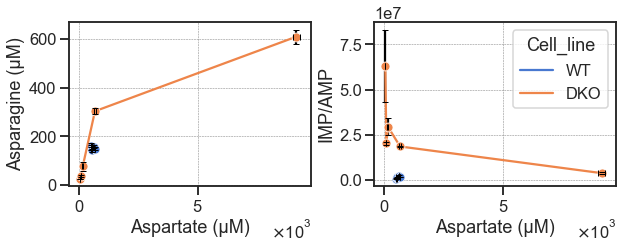

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.8))


g1 = sns.lineplot(ax=ax1, data=df_mean, x='Aspartate conc', y='Asparagine conc', hue='Cell_line', markers=True, marker='o', hue_order=['WT', 'DKO'])

g1.errorbar(y=df_mean['Asparagine conc'].values, x=df_mean['Aspartate conc'].values, xerr=df_stdev['Aspartate conc'].values, yerr=df_stdev['Asparagine conc'].values, fmt='none', color='black', capsize=3)
g1.grid(True, which="both", ls="--", c='gray', linewidth=0.5)

g1.set(ylabel='Asparagine (μM)', xlabel='Aspartate (μM)')
g1.ticklabel_format(axis='x', style='sci', scilimits=[0, 0], useMathText=True)

g1.legend_.remove()


g2 = sns.lineplot(ax=ax2, data=df_mean, x='Aspartate conc', y='IMP-AMP', hue='Cell_line', markers=True, marker='o', hue_order=['WT', 'DKO'])

g2.errorbar(y=df_mean['IMP-AMP'].values, x=df_mean['Aspartate conc'].values, xerr=df_stdev['Aspartate conc'].values, yerr=df_stdev['IMP-AMP'].values, fmt='none', color='black', capsize=3)
g2.grid(True, which="both", ls="--", c='gray', linewidth=0.5)

g2.set(xlabel='Aspartate (μM)', ylabel='IMP/AMP')
g2.ticklabel_format(axis='x', style='sci', scilimits=[0, 0], useMathText=True)

### Stupid hack to get rid of overlapping label:
#g2.xaxis.get_minorticklabels()[17].set_visible(False)


plt.tight_layout()
fig.savefig('plots/combined-Asp-fates.pdf')

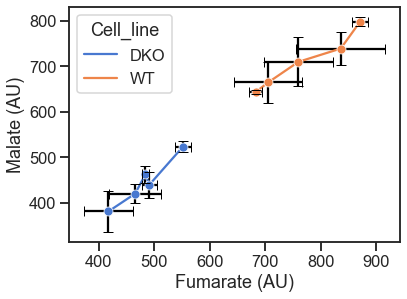

In [46]:
### Malate as a function of Fumarate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Fum_vs_Mal_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean, y='Malate neg', x='Fumarate neg', markers=True, hue='Cell_line', marker='o')

g.errorbar(y=df_mean['Malate neg'].values, x=df_mean['Fumarate neg'].values, xerr=df_stdev['Fumarate neg'].values, yerr=df_stdev['Malate neg'].values, fmt='none', color='black', capsize=5)

plt.ylabel('Malate (AU)')#, size=12);
plt.xlabel('Fumarate (AU)')#, size=12);
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

In [11]:
# Prepare for plotting:
df_mean_melt = pd.melt(df_norm_mean, id_vars=['UCPH', 'Proliferation_rate', 'Aspartate conc', 'Cell_line'], var_name='Metabolite', value_name='value')
df_mean_melt['Metabolite'] = [m[:-4] if m[-3:] == 'neg' or m[-3:] == 'pos' else m for m in df_mean_melt['Metabolite'].values]

df_stdev_melt = pd.melt(df_norm_stdev, id_vars=['UCPH', 'Proliferation_rate', 'Aspartate conc', 'Cell_line'], var_name='Metabolite', value_name='value')
df_stdev_melt['Metabolite'] = [m[:-4] if m[-3:] == 'neg' or m[-3:] == 'pos' else m for m in df_stdev_melt['Metabolite'].values]

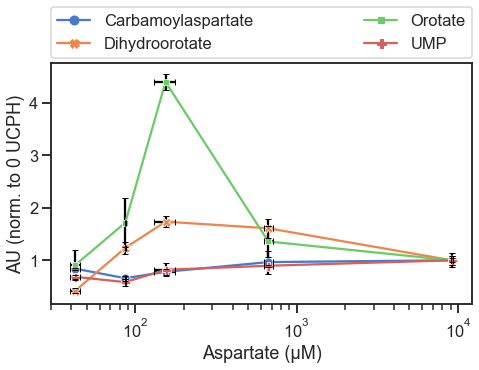

In [12]:
### Pyrimidine synthesis is blocked at DHODH ###

pdf = matplotlib.backends.backend_pdf.PdfPages("DHODH_vs_Asp.pdf")
fig = plt.figure(figsize=(7, 5.5))
metab_list = ['Carbamoylaspartate', 'Dihydroorotate', 'Orotate', 'UMP']
mask = (df_mean_melt['Metabolite'].isin(metab_list)) & (df_mean_melt['Cell_line'] == 'DKO')
g1 = sns.lineplot(data=df_mean_melt[mask], y='value', x='Aspartate conc', markers=True, dashes=False, hue='Metabolite', style='Metabolite')

g1.errorbar(y=df_mean_melt[mask]['value'].values, x=df_mean_melt[mask]['Aspartate conc'].values, yerr=df_stdev_melt[mask]['value'].values, xerr=df_stdev_melt[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=3)
g1.set(xscale="log");
g1.set(xlabel='Aspartate (μM)', ylabel='AU (norm. to 0 UCPH)')

g1.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

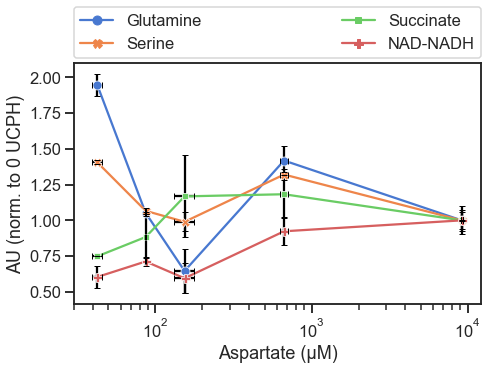

In [68]:
### Pyrimidine synthesis is blocked at DHODH ###

#pdf = matplotlib.backends.backend_pdf.PdfPages("DHODH_vs_Asp.pdf")
fig = plt.figure(figsize=(7, 5.5))
metab_list = ['Glutamine', 'Serine', 'Succinate', 'NAD-NADH']
mask = (df_mean_melt['Metabolite'].isin(metab_list)) & (df_mean_melt['Cell_line'] == 'DKO')
g1 = sns.lineplot(data=df_mean_melt[mask], y='value', x='Aspartate conc', markers=True, dashes=False, hue='Metabolite', style='Metabolite')

g1.errorbar(y=df_mean_melt[mask]['value'].values, x=df_mean_melt[mask]['Aspartate conc'].values, yerr=df_stdev_melt[mask]['value'].values, xerr=df_stdev_melt[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=3)
g1.set(xscale="log");
g1.set(xlabel='Aspartate (μM)', ylabel='AU (norm. to 0 UCPH)')

g1.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)
plt.tight_layout()

#pdf.savefig(fig)
plt.show(fig)
#plt.close(fig)
#pdf.close()

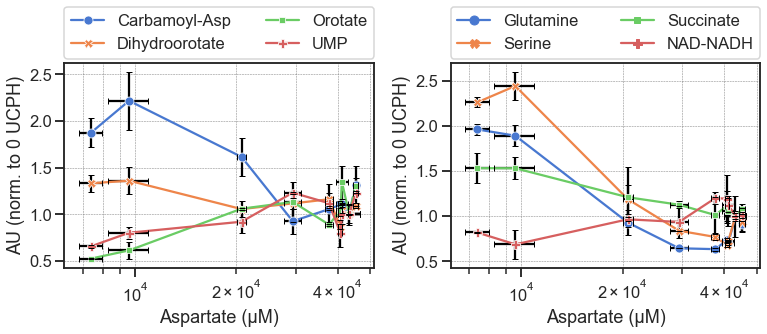

In [382]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), gridspec_kw={'width_ratios': [1, 1]})


metab_list = ['Carbamoylaspartate', 'Dihydroorotate', 'Orotate', 'UMP']
mask = df_mean_melt['Metabolite'].isin(metab_list)
g1 = sns.lineplot(ax=ax1, data=df_mean_melt[mask], y='value', x='Aspartate conc', markers=True, dashes=False, hue='Metabolite', style='Metabolite')

g1.errorbar(y=df_mean_melt[mask]['value'].values, x=df_mean_melt[mask]['Aspartate conc'].values, yerr=df_stdev_melt[mask]['value'].values, xerr=df_stdev_melt[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=3)
g1.set(xscale="log");
g1.set(xlabel='Aspartate (μM)', ylabel='AU (norm. to 0 UCPH)')
### Stupid hack to get rid of overlapping label:
g1.xaxis.get_minorticklabels()[17].set_visible(False)
g1.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
g1.legend(['Carbamoyl-Asp','Dihydroorotate', 'Orotate', 'UMP'], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)





metab_list = ['Glutamine', 'Serine', 'Succinate', 'NAD-NADH']
mask = df_mean_melt['Metabolite'].isin(metab_list)
g2 = sns.lineplot(ax=ax2, data=df_mean_melt[mask], y='value', x='Aspartate conc', markers=True, dashes=False, hue='Metabolite', style='Metabolite')

g2.errorbar(y=df_mean_melt[mask]['value'].values, x=df_mean_melt[mask]['Aspartate conc'].values, yerr=df_stdev_melt[mask]['value'].values, xerr=df_stdev_melt[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=3)
g2.set(xscale="log");
g2.set(xlabel='Aspartate (μM)', ylabel='AU (norm. to 0 UCPH)')
### Stupid hack to get rid of overlapping label:
g2.xaxis.get_minorticklabels()[17].set_visible(False)
g2.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
g2.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)



plt.tight_layout()
fig.savefig('combined-ETCinhib.pdf')